In [7]:
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, rmse, mae, exp_var, rsquared
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

import matplotlib.pyplot as plt

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas version: 1.5.3
Tensorflow version: 2.11.0


<h1>Load data</h1>

In [8]:
def deduplicate(df):
    min_v, max_v = df['rating'].min(), df['rating'].max()
    df = df.groupby(['userID', 'itemID'], as_index=False).agg({'rating': 'sum', 'timestamp': 'max'})
    df['rating'] = np.clip(df['rating'], min_v, max_v)
    return df


def load(dataset_name):
    train_file = "../data/{}/train.csv".format(dataset_name)
    test_file = "../data/{}/test.csv".format(dataset_name)

    train = pd.read_csv(train_file)
    test  = pd.read_csv(test_file)

    train = deduplicate(train)
    test = deduplicate(test)
    
    print(train['userID'].nunique(), train['itemID'].nunique())

    #to use standard names across the analysis 
    header = {
            "col_user": "userID",
            "col_item": "itemID",
            "col_rating": "rating",
        }

    #instantiate the sparse matrix generation
    am = AffinityMatrix(df = train, **header)
    #obtain the sparse matrix, users x items
    Xtr, u, i = am.gen_affinity_matrix()

    Xtst = np.zeros_like(Xtr)
    for indx, (user, item, rating, timestamp) in test.iterrows():
        u_index = u[user]
        i_index = i[item]

        Xtst[u_index][i_index] = rating

    print('train matrix size', Xtr.shape)
    print('test matrix size', Xtst.shape)

    return Xtr, Xtst, am

<h1>Train the RBM model</h1>

In [9]:
def init_RBM(Xtr, epoch=3, hidden_units=140):
    #First we initialize the model class
    model = RBM(
        possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
        #possible_ratings=np.unique(Xtr), # this should be set only for steam
        visible_units=Xtr.shape[1],
        hidden_units=hidden_units,
        training_epoch=epoch,
        minibatch_size=70,
        keep_prob=0.75,
        with_metrics=True
    )
    return model

In [13]:
class RBM_recsys():
    def __init__(self, name='sas'):
        # load data
        self.Xtr, self.Xtst, self.am = load(name)

        epochs = {
            'movielens': 30,
            'steam': 8,
            'goodreads': 3,
            'sas': 4,
        }
        hidden_units = {
            'movielens': 100,
            'steam': 100,
            'goodreads': 140,
            'sas': 240,
        }
        # init rbm
        self.model = init_RBM(self.Xtr, epochs[name], hidden_units[name])

    def fit(self):
        # Model Fit
        with Timer() as train_time:
            self.model.fit(self.Xtr)

        print("Took {:.2f} seconds for training.".format(train_time.interval))
        # Plot the train RMSE as a function of the epochs
        line_graph(values=self.model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

    def get_user_recommendations(self, remove_seen=True):
        # Model prediction on the test set Xtst.
        with Timer() as prediction_time:
            top_k = self.model.recommend_k_items(self.Xtst, 50, remove_seen=True)

        print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

        top_k_df = self.am.map_back_sparse(top_k, kind = 'prediction')
        test_df = self.am.map_back_sparse(self.Xtst, kind = 'ratings')

        return top_k_df, test_df
    
    #######################
    def map_k(self, data_true, data_pred, K):
        return map_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def ndcg_k(self, data_true, data_pred, K):
        return ndcg_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def precision_k(self, data_true, data_pred, K):
        return precision_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def recall_k(self, data_true, data_pred, K):
        return recall_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)


    def get_all_scores(self):

        top_ex, test_df = self.get_user_recommendations(remove_seen=True)
        top_k_df, test_df = self.get_user_recommendations(remove_seen=False)

        exc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [self.map_k(test_df, top_ex, 5), self.map_k(test_df, top_ex, 10), self.map_k(test_df, top_ex, 50)],
            'NDCG': [self.ndcg_k(test_df, top_ex, 5), self.ndcg_k(test_df, top_ex, 10), self.ndcg_k(test_df, top_ex, 50)],
            'Precision': [self.precision_k(test_df, top_ex, 5), self.precision_k(test_df, top_ex, 10), self.precision_k(test_df, top_ex, 50)],
            'Recall': [self.recall_k(test_df, top_ex, 5), self.recall_k(test_df, top_ex, 10), self.recall_k(test_df, top_ex, 50)],
        })

        inc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [self.map_k(test_df, top_k_df, 5), self.map_k(test_df, top_k_df, 10), self.map_k(test_df, top_k_df, 50)],
            'NDCG': [self.ndcg_k(test_df, top_k_df, 5), self.ndcg_k(test_df, top_k_df, 10), self.ndcg_k(test_df, top_k_df, 50)],
            'Precision': [self.precision_k(test_df, top_k_df, 5), self.precision_k(test_df, top_k_df, 10), self.precision_k(test_df, top_k_df, 50)],
            'Recall': [self.recall_k(test_df, top_k_df, 5), self.recall_k(test_df, top_k_df, 10), self.recall_k(test_df, top_k_df, 50)],
        })

        merged = pd.merge(test_df, top_k_df, on=('userID', 'itemID'))

        data_true = merged[['userID', 'itemID', 'rating']]
        data_pred = merged[['userID', 'itemID', 'prediction']]

        eval_rmse = rmse(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
        eval_mae = mae(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
        eval_exp_var = exp_var(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
        eval_rsquared = rsquared(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")

        inc_seen_rait = pd.DataFrame({
            'RMSE': [eval_rmse],
            'MAE': [eval_mae],
            'Exp Var': [eval_exp_var],
            'R squared': [eval_rsquared]
        }) 

        return exc_seen_rank, inc_seen_rank, inc_seen_rait
        

In [14]:
def full_train(ds_name):
    als_recsys = RBM_recsys(ds_name)
    als_recsys.fit()
    return als_recsys.get_all_scores()

47759 2184
train matrix size (47759, 2184)
test matrix size (47759, 2184)


2023-05-09 14:12:16.884049: W tensorflow/c/c_api.cc:291] Operation '{name:'key_value_init/LookupTableImportV2' id:6 op device:{requested: '', assigned: ''} def:{{{node key_value_init/LookupTableImportV2}} = LookupTableImportV2[Tin=DT_INT32, Tout=DT_FLOAT, _has_manual_control_dependencies=true](hash_table, Const, Const_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Took 35.61 seconds for training.
Took 34.97 seconds for prediction.
Took 39.88 seconds for prediction.


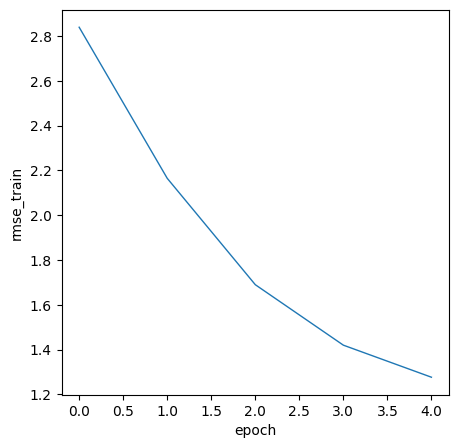

In [15]:
exc_seen_rank, inc_seen_rank, inc_seen_rait = full_train('sas')

In [16]:
exc_seen_rank.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_20756/3256864183.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  exc_seen_rank.style.hide_index()


TOP_K,MAP,NDCG,Precision,Recall
5,0.039661,0.053872,0.025265,0.057148
10,0.042524,0.059607,0.016838,0.075557
50,0.045506,0.072493,0.005701,0.120600


In [19]:
inc_seen_rank.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_20756/1931737838.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  inc_seen_rank.style.hide_index()


TOP_K,MAP,NDCG,Precision,Recall
5,0.044064,0.059138,0.027195,0.062581
10,0.047046,0.065135,0.018044,0.081708
50,0.049229,0.073535,0.005083,0.109911


In [18]:
inc_seen_rait.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_20756/3271275326.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  inc_seen_rait.style.hide_index()


RMSE,MAE,Exp Var,R squared
1.524428,1.253711,0.218362,0.104112


<h3>SAS RFM</h3>

In [1]:
from copy import deepcopy

In [5]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

47759 2184
train matrix size (47759, 2184)
test matrix size (47759, 2184)


2023-05-09 14:09:57.718107: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-05-09 14:09:57.723374: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-09 14:09:57.947511: W tensorflow/c/c_api.cc:291] Operation '{name:'key_value_init/LookupTableImportV2' id:6 op device:{requested: '', assigned: ''} def:{{{node key_value_init/LookupTableImportV2}} = LookupTableImportV2[Tin=DT_INT32, Tout=DT_FLOAT, _has_manual_control_dependencies=true](hash_table, Const, Const_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Took 32.12 seconds for training.
Took 35.61 seconds for prediction.


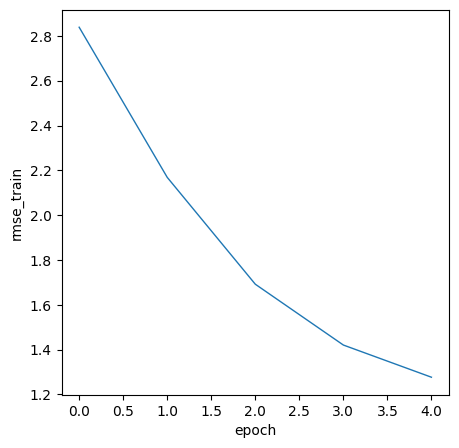

In [11]:
als_recsys = RBM_recsys('sas')
als_recsys.fit()
top_ex, test_df = als_recsys.get_user_recommendations(remove_seen=True)
merged_pred = deepcopy(top_ex)
merged_test = deepcopy(test_df)

In [12]:
ndcg_at_k(merged_test, merged_pred, col_prediction='prediction', k=10)

0.05773961144108822

In [21]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(5532, 3) (141800, 3)
(3455, 3) (144850, 3)
(4055, 3) (212500, 3)
(4344, 3) (292450, 3)
(2694, 3) (255300, 3)
(572, 3) (96600, 3)


In [22]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.041
Champions 0.0466
Loyal 0.0373
Potential 0.0458
Sleeping 0.0544
Require Activation 0.0687


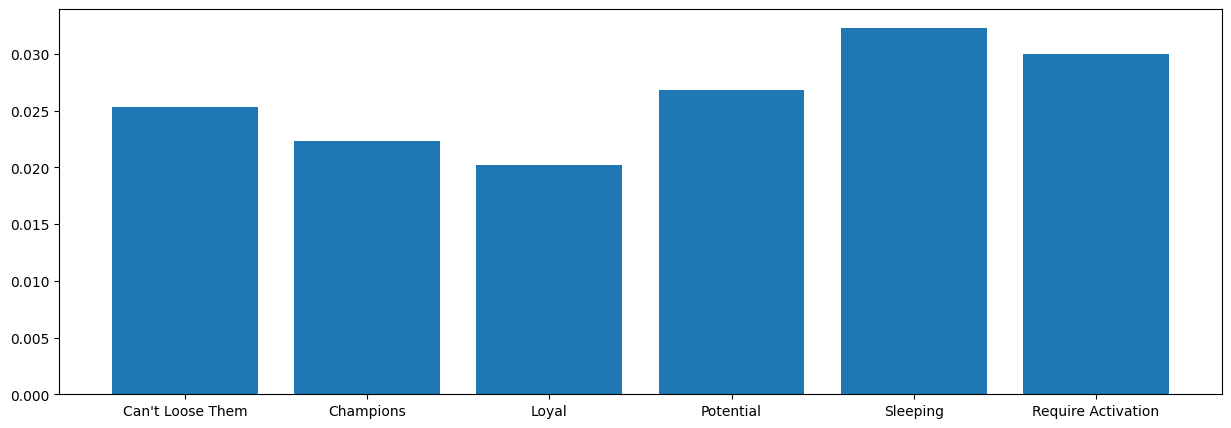

In [31]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);

<h1>Saving the model and Loading a pre-trained model</h1>

In [ ]:
#model.save(file_path='./models/rbm_model.ckpt')